**Training using SA + CA + RAD**

In [1]:
import torch
torch.cuda.is_available()

True

In [22]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Additional information about the CUDA device
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


Using device: cuda
NVIDIA GeForce RTX 2070 SUPER


In [3]:
import os
import numpy as np
from PIL import Image

def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

def get_subdirs(directory):
    subdirs = sorted([os.path.join(directory, name) for name in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, name))])
    return subdirs

class ExternalInputIterator:
    def __init__(self, imageset_dir, batch_size, random_shuffle=False):
        self.imageset_dir = imageset_dir
        self.batch_size = batch_size

        # Get subdirectories (assuming "pose" and "frontal" folders exist)
        #self.pose_dirs = get_subdirs(os.path.join(imageset_dir, "pose"))
        self.pose_dirs = os.path.join(imageset_dir, "pose")
        self.frontal_dir = os.path.join(imageset_dir, "frontal")
        print(self.frontal_dir)
        print(self.pose_dirs)

        # Collect profile image paths
        self.profile_files = []
        #for pose_dir in self.pose_dirs:
        profile_files = [os.path.join(self.pose_dirs, file) for file in sorted(os.listdir(self.pose_dirs)) if is_jpeg(file)]
        self.profile_files.extend(profile_files)
        print(len(self.profile_files))

        # Collect frontal image paths
        self.frontal_files = [os.path.join(self.frontal_dir, file) for file in sorted(os.listdir(self.frontal_dir)) if is_jpeg(file)]
        print(len(self.frontal_files))

        # Shuffle if necessary
        if random_shuffle:
            np.random.shuffle(self.profile_files)
            np.random.shuffle(self.frontal_files)

        self.i = 0
        self.n = len(self.profile_files)

    def __iter__(self):
        return self

    def __next__(self):
        profiles = []
        frontals = []

        for _ in range(self.batch_size):
            profile_filename = self.profile_files[self.i]
            frontal_filename = self.match_frontal_image(profile_filename)

            with Image.open(profile_filename) as profile_img:
                profiles.append(np.array(profile_img))
            with Image.open(frontal_filename) as frontal_img:
                frontals.append(np.array(frontal_img))

            self.i = (self.i + 1) % self.n

        return (profiles, frontals)

    def match_frontal_image(self, profile_filename):
        profile_name = os.path.basename(profile_filename).split("_")[0]
        for frontal_file in self.frontal_files:
            if profile_name in frontal_file:
                return frontal_file
        return None

class ImagePipeline:
    def __init__(self, imageset_dir, image_size=128, random_shuffle=False, batch_size=64,device_id = 0):
        self.eii = ExternalInputIterator(imageset_dir, batch_size, random_shuffle)
        self.iterator = iter(self.eii)
        self.num_inputs = len(self.eii.profile_files)
        self.image_size = image_size

    def epoch_size(self, name=None):
        return self.num_inputs

    def __len__(self):
        return self.num_inputs

    def __iter__(self):
        return self

    def __next__(self):
        (images, targets) = next(self.iterator)

        # Perform resizing and normalization using NumPy
        resized_images = np.array([np.array(Image.fromarray(img).resize((self.image_size, self.image_size))) for img in images])
        resized_targets = np.array([np.array(Image.fromarray(target).resize((self.image_size, self.image_size))) for target in targets])

        # Calculate mean and standard deviation for each channel separately
        #mean = np.array([0.5, 0.5, 0.5])  # Assuming RGB images have pixel values in [0, 255] range
        #std = np.array([0.5, 0.5, 0.5])   # Assuming RGB images have pixel values in [0, 255] range
        
        # Normalize each channel independently
        #normalized_images = (resized_images / 255.0 - mean) / std
        #normalized_targets = (resized_targets / 255.0 - mean) / std


        # Normalize using mean and standard deviation
        normalized_images = (resized_images - 128.0) / 128.0
        normalized_targets = (resized_targets - 128.0) / 128.0

        return (normalized_images, normalized_targets)

    def __getitem__(self, index):
        # Advance the iterator to the desired index
        for _ in range(index):
            next(self.iterator)

        # Return the next batch
        return next(self)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

**Self attention**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma * out + x
        return out

**Channel attention**

In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)
        avg_out = self.fc(avg_pool)
        max_out = self.fc(max_pool)
        out = avg_out + max_out
        return out * x


In [7]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            ChannelAttention(64)  # Add channel attention
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),         # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ChannelAttention(128)  # Add channel attention
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),        # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ChannelAttention(256)  # Add channel attention
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),        # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            ChannelAttention(512)  # Add channel attention
        )
        self.encoder5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),        # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            ChannelAttention(512)  # Add channel attention
        )
        self.encoder6 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),        # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            ChannelAttention(512)  # Add channel attention
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 4, 2, 1),       # 1x1
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),   # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, 2, 1),   # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            SelfAttention(256)  # Add self-attention
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1),   # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            SelfAttention(128)  # Add self-attention
        )
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.decoder6 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, 2, 1),  # 128x128
            nn.Tanh()
        )

    def forward(self, x):
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        enc6 = self.encoder6(enc5)

        # Bottleneck
        bottleneck = self.bottleneck(enc6)

        # Decoding and adding skip connection
        dec1 = self.decoder1(torch.cat([bottleneck, enc6], dim=1))
        dec2 = self.decoder2(torch.cat([dec1, enc5], dim=1))
        dec3 = self.decoder3(torch.cat([dec2, enc4], dim=1))
        dec4 = self.decoder4(torch.cat([dec3, enc3], dim=1))
        dec5 = self.decoder5(torch.cat([dec4, enc2], dim=1))
        decoded = self.decoder6(torch.cat([dec5, enc1], dim=1))

        return decoded

# Example usage:
# generator = G()
# generator.apply(weights_init)
# print(generator)


**Relative average discriminator**

In [8]:
import torch
from torch import nn

class RelativeAvgDiscriminator(nn.Module):
  def __init__(self):
    super(RelativeAvgDiscriminator, self).__init__()

    # Separate feature extraction for real and generated data
    self.conv_real = nn.Sequential(
        nn.Conv2d(1, 16, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(16, 32, 4, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(32, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.conv_generated = nn.Sequential(
        nn.Conv2d(1, 16, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(16, 32, 4, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(32, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
    )

    # Relative Average Pooling
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    # Remaining convolutional layers (modified for combined features)
    self.post_pool = nn.Sequential(
        nn.Conv2d(128, 128, 4, 2, 1),  # Input channels changed to 128
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
       
    )

    # Output layer with sigmoid activation
    self.output = nn.Sigmoid()

  def forward(self, real, fake):
    # Extract features from real and generated data
    real_features = self.conv_real(real)
    generated_features = self.conv_generated(fake)

    # Concatenate features before pooling
    combined_features = torch.cat([real_features, generated_features], dim=1)

    # Relative Average Pooling
    features = self.avgpool(combined_features)

    # Process features with remaining layers
    output = self.post_pool(features)

    # Probability score
    #probability = self.output(logits)

    return output


In [11]:
from __future__ import print_function
import time
import math
import random
import os
from os import listdir
from os.path import join
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#from nvidia.dali.plugin.pytorch import DALIGenericIterator

#from data import ImagePipeline
#import network

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)
# Where is your training dataset at?
datapath =r"C:\Users\zed\Dataset\\Grayscale_Dataset"

# You can also choose which GPU you want your model to be trained on below:
#gpu_id = 0
#device = torch.device("cuda", gpu_id)

checkpoint_dir = "checkpoints"

"""train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=30, device_id=gpu_id)
train_pipe.build()
m_train = train_pipe.epoch_size()
print("Size of the training set: ", m_train)
train_pipe_loader = DALIGenericIterator(train_pipe, ["profiles", "frontals"], m_train)"""
# Assuming you have the modified ImagePipeline class from the previous responses
train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=32, device_id=gpu_id)
# No need to call build() without DALI

# Use a standard PyTorch DataLoader instead of DALIGenericIterator
#train_pipe_loader = DataLoader(train_pipe, batch_size=train_pipe.batch_size)
m_train = train_pipe.epoch_size()
#train_pipe_loader = DataLoader(train_pipe, batch_size=32,)
train_pipe_loader = DataLoader(train_pipe,)

criterion = nn.BCEWithLogitsLoss()

C:\Users\zed\Dataset\\Grayscale_Dataset\frontal
C:\Users\zed\Dataset\\Grayscale_Dataset\pose
220
70


**PSNR and SSIM**

In [12]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from tqdm import tqdm
from torch.autograd import Variable
from skimage.metrics import structural_similarity as ssim

# Define a function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Define a function to calculate SSIM
# Define a function to calculate SSIM
def calculate_ssim(img1, img2):
    # Ensure tensors are on the same device
    if img1.device != img2.device:
        raise ValueError("Input tensors must be on the same device")

    # Calculate SSIM directly on GPU tensors
    img1 = img1.detach().squeeze().clamp(0, 1).cpu().numpy()  # Ensure pixel values are in [0, 1] range
    img2 = img2.detach().squeeze().clamp(0, 1).cpu().numpy()  # Ensure pixel values are in [0, 1] range
    return ssim(img1.transpose(1, 2, 0), img2.transpose(1, 2, 0), multichannel=True, data_range=1)


# Define lists to store PSNR and SSIM values for each epoch
psnr_values = []
ssim_values = []

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
from tqdm import tqdm
import os
import time

#gpu_id = 0
#device = torch.device("cuda", gpu_id)

netG = G().to(device)
netG.apply(weights_init)

netD = RelativeAvgDiscriminator().to(device)
netD.apply(weights_init)

L1_factor = 1
L2_factor = 1
GAN_factor = 0.005

#criterion = nn.BCEWithLogitsLoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-8)

try:
    os.mkdir('FF_output')
except OSError:
    pass

try:
    os.mkdir('FF_checkpoints')
except OSError:
    pass
    


In [13]:
checkpoint_dir = "FF_checkpoints"

In [14]:
# Lists to store the losses
losses_L1 = []
losses_L2 = []
losses_gan = []


**MULTI-SCALE PIXEL WISE LOSS**

In [15]:
import torch
import torch.nn.functional as F

def multi_scale_pixelwise_loss(fake_images, real_images, num_scales=3):
    loss = 0.0
    for scale in range(num_scales):
        fake_scaled = F.interpolate(fake_images, scale_factor=1 / (2 ** scale), mode='bilinear', align_corners=False)
        real_scaled = F.interpolate(real_images, scale_factor=1 / (2 ** scale), mode='bilinear', align_corners=False)
        pixel_loss = F.l1_loss(fake_scaled, real_scaled)
        loss += pixel_loss / (2 ** scale)
    return loss


In [16]:
# Initialize lists to store losses
generator_losses = []
discriminator_losses = []
multi_scale_losses = []

avg_generator_losses = []
avg_discriminator_losses = []
avg_multi_scale_losses = []

In [17]:
start_time = time.time()

In [ ]:
for epoch in range(100):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            #errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FF_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FF_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FF_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FF_output/netG_%d.pt' % epoch)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:48<00:00,  3.22s/it]


First training epoch completed in  724.3561129570007  seconds
[1/30] Training absolute losses: L1 0.0728236 ; L2 0.0042597 BCE 0.6762871; Average PSNR: 23.92; Average SSIM: 0.9026


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[2/30] Training absolute losses: L1 0.0518000 ; L2 0.0021811 BCE 0.6920716; Average PSNR: 26.73; Average SSIM: 0.9494


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:39<00:00,  3.18s/it]


[3/30] Training absolute losses: L1 0.0420956 ; L2 0.0014374 BCE 0.7025382; Average PSNR: 28.53; Average SSIM: 0.9666


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[4/30] Training absolute losses: L1 0.0368968 ; L2 0.0010934 BCE 0.7071131; Average PSNR: 29.74; Average SSIM: 0.9728


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:28<00:00,  3.13s/it]


[5/30] Training absolute losses: L1 0.0343746 ; L2 0.0009184 BCE 0.7088974; Average PSNR: 30.53; Average SSIM: 0.9754


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:29<00:00,  3.13s/it]


[6/30] Training absolute losses: L1 0.0319183 ; L2 0.0007853 BCE 0.7100956; Average PSNR: 31.23; Average SSIM: 0.9777


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[7/30] Training absolute losses: L1 0.0311533 ; L2 0.0007247 BCE 0.7108912; Average PSNR: 31.63; Average SSIM: 0.9791


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.15s/it]


[8/30] Training absolute losses: L1 0.0306637 ; L2 0.0006651 BCE 0.7117364; Average PSNR: 31.98; Average SSIM: 0.9808


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:29<00:00,  3.13s/it]


[9/30] Training absolute losses: L1 0.0286534 ; L2 0.0005915 BCE 0.7125019; Average PSNR: 32.55; Average SSIM: 0.9829


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[10/30] Training absolute losses: L1 0.0276275 ; L2 0.0005403 BCE 0.7133658; Average PSNR: 32.97; Average SSIM: 0.9846


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:54<00:00,  3.25s/it]


[11/30] Training absolute losses: L1 0.0247453 ; L2 0.0004488 BCE 0.7137544; Average PSNR: 33.77; Average SSIM: 0.9876


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[12/30] Training absolute losses: L1 0.0249455 ; L2 0.0004399 BCE 0.7146766; Average PSNR: 33.91; Average SSIM: 0.9878


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[13/30] Training absolute losses: L1 0.0243278 ; L2 0.0004162 BCE 0.7151302; Average PSNR: 34.16; Average SSIM: 0.9882


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:36<00:00,  3.16s/it]


[14/30] Training absolute losses: L1 0.0522812 ; L2 0.0070756 BCE 0.7158939; Average PSNR: 30.02; Average SSIM: 0.9393


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:37<00:00,  3.17s/it]


[15/30] Training absolute losses: L1 0.0222409 ; L2 0.0003687 BCE 0.7170622; Average PSNR: 34.55; Average SSIM: 0.9898


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[16/30] Training absolute losses: L1 0.0232919 ; L2 0.0003759 BCE 0.7176378; Average PSNR: 34.59; Average SSIM: 0.9890


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [12:08<00:00,  3.31s/it]


[17/30] Training absolute losses: L1 0.0229339 ; L2 0.0003563 BCE 0.7180282; Average PSNR: 34.86; Average SSIM: 0.9896


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[18/30] Training absolute losses: L1 0.0229160 ; L2 0.0003501 BCE 0.7189645; Average PSNR: 35.00; Average SSIM: 0.9895


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[19/30] Training absolute losses: L1 0.0233727 ; L2 0.0003560 BCE 0.7197096; Average PSNR: 34.92; Average SSIM: 0.9889


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[20/30] Training absolute losses: L1 0.0227461 ; L2 0.0003379 BCE 0.7202731; Average PSNR: 35.19; Average SSIM: 0.9896


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[21/30] Training absolute losses: L1 0.0222319 ; L2 0.0003214 BCE 0.7209411; Average PSNR: 35.40; Average SSIM: 0.9902


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:35<00:00,  3.16s/it]


[22/30] Training absolute losses: L1 0.0214807 ; L2 0.0003010 BCE 0.7216542; Average PSNR: 35.73; Average SSIM: 0.9907


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.15s/it]


[23/30] Training absolute losses: L1 0.0211422 ; L2 0.0002894 BCE 0.7222280; Average PSNR: 35.89; Average SSIM: 0.9911


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[24/30] Training absolute losses: L1 0.0204050 ; L2 0.0002710 BCE 0.7229393; Average PSNR: 36.17; Average SSIM: 0.9916


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[25/30] Training absolute losses: L1 0.0199476 ; L2 0.0002603 BCE 0.7234667; Average PSNR: 36.35; Average SSIM: 0.9920


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[26/30] Training absolute losses: L1 0.0195989 ; L2 0.0002493 BCE 0.7237519; Average PSNR: 36.54; Average SSIM: 0.9924


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[27/30] Training absolute losses: L1 0.0191446 ; L2 0.0002380 BCE 0.7244876; Average PSNR: 36.74; Average SSIM: 0.9929


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[28/30] Training absolute losses: L1 0.0188293 ; L2 0.0002314 BCE 0.7252806; Average PSNR: 36.83; Average SSIM: 0.9929


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:35<00:00,  3.16s/it]


[29/30] Training absolute losses: L1 0.0185673 ; L2 0.0002242 BCE 0.7258543; Average PSNR: 36.97; Average SSIM: 0.9932


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:39<00:00,  3.18s/it]


[30/30] Training absolute losses: L1 0.0185031 ; L2 0.0002228 BCE 0.7262465; Average PSNR: 37.05; Average SSIM: 0.9931


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[31/30] Training absolute losses: L1 0.0179544 ; L2 0.0002122 BCE 0.7263723; Average PSNR: 37.24; Average SSIM: 0.9935


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[32/30] Training absolute losses: L1 0.0181192 ; L2 0.0002112 BCE 0.7272551; Average PSNR: 37.27; Average SSIM: 0.9938


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[33/30] Training absolute losses: L1 0.0260883 ; L2 0.0024860 BCE 0.7272695; Average PSNR: 34.82; Average SSIM: 0.9737


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[34/30] Training absolute losses: L1 0.0170235 ; L2 0.0001890 BCE 0.7284568; Average PSNR: 37.68; Average SSIM: 0.9948


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[35/30] Training absolute losses: L1 0.0173810 ; L2 0.0001929 BCE 0.7287960; Average PSNR: 37.60; Average SSIM: 0.9946


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:40<00:00,  3.18s/it]


[36/30] Training absolute losses: L1 0.0170966 ; L2 0.0001861 BCE 0.7288055; Average PSNR: 37.75; Average SSIM: 0.9947


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[37/30] Training absolute losses: L1 0.0170044 ; L2 0.0001842 BCE 0.7291715; Average PSNR: 37.78; Average SSIM: 0.9948


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[38/30] Training absolute losses: L1 0.0167849 ; L2 0.0001795 BCE 0.7295132; Average PSNR: 37.92; Average SSIM: 0.9950


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[39/30] Training absolute losses: L1 0.0166203 ; L2 0.0001747 BCE 0.7299375; Average PSNR: 38.04; Average SSIM: 0.9952


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:36<00:00,  3.16s/it]


[40/30] Training absolute losses: L1 0.0164420 ; L2 0.0001715 BCE 0.7301857; Average PSNR: 38.14; Average SSIM: 0.9954


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[41/30] Training absolute losses: L1 0.0161879 ; L2 0.0001668 BCE 0.7304983; Average PSNR: 38.27; Average SSIM: 0.9955


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:37<00:00,  3.17s/it]


[42/30] Training absolute losses: L1 0.0157537 ; L2 0.0001586 BCE 0.7296467; Average PSNR: 38.50; Average SSIM: 0.9956


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:37<00:00,  3.17s/it]


[43/30] Training absolute losses: L1 0.0154907 ; L2 0.0001537 BCE 0.7319132; Average PSNR: 38.63; Average SSIM: 0.9958


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:36<00:00,  3.16s/it]


[44/30] Training absolute losses: L1 0.0154269 ; L2 0.0001515 BCE 0.7317158; Average PSNR: 38.71; Average SSIM: 0.9959


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[45/30] Training absolute losses: L1 0.0152984 ; L2 0.0001492 BCE 0.7314531; Average PSNR: 38.79; Average SSIM: 0.9959


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[46/30] Training absolute losses: L1 0.0149646 ; L2 0.0001434 BCE 0.7314888; Average PSNR: 39.00; Average SSIM: 0.9961


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:30<00:00,  3.14s/it]


[47/30] Training absolute losses: L1 0.0149007 ; L2 0.0001408 BCE 0.7315514; Average PSNR: 39.07; Average SSIM: 0.9962


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[48/30] Training absolute losses: L1 0.0150152 ; L2 0.0001473 BCE 0.7316042; Average PSNR: 38.96; Average SSIM: 0.9960


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[49/30] Training absolute losses: L1 0.0145711 ; L2 0.0001343 BCE 0.7320102; Average PSNR: 39.28; Average SSIM: 0.9964


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[50/30] Training absolute losses: L1 0.0142602 ; L2 0.0001285 BCE 0.7319013; Average PSNR: 39.46; Average SSIM: 0.9966


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[51/30] Training absolute losses: L1 0.0140287 ; L2 0.0001259 BCE 0.7322498; Average PSNR: 39.59; Average SSIM: 0.9966


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[52/30] Training absolute losses: L1 0.0138388 ; L2 0.0001249 BCE 0.7321870; Average PSNR: 39.70; Average SSIM: 0.9966


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.15s/it]


[53/30] Training absolute losses: L1 0.0138722 ; L2 0.0001219 BCE 0.7319062; Average PSNR: 39.74; Average SSIM: 0.9968


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[54/30] Training absolute losses: L1 0.0138461 ; L2 0.0001203 BCE 0.7322530; Average PSNR: 39.72; Average SSIM: 0.9969


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[55/30] Training absolute losses: L1 0.0137453 ; L2 0.0001186 BCE 0.7320902; Average PSNR: 39.81; Average SSIM: 0.9969


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[56/30] Training absolute losses: L1 0.0135997 ; L2 0.0001178 BCE 0.7321580; Average PSNR: 39.90; Average SSIM: 0.9970


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:30<00:00,  3.14s/it]


[57/30] Training absolute losses: L1 0.0135879 ; L2 0.0001151 BCE 0.7322403; Average PSNR: 39.94; Average SSIM: 0.9972


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[58/30] Training absolute losses: L1 0.0132400 ; L2 0.0001108 BCE 0.7323798; Average PSNR: 40.08; Average SSIM: 0.9972


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[59/30] Training absolute losses: L1 0.0181937 ; L2 0.0011557 BCE 0.7321802; Average PSNR: 37.84; Average SSIM: 0.9898


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[60/30] Training absolute losses: L1 0.0131335 ; L2 0.0001094 BCE 0.7322371; Average PSNR: 40.14; Average SSIM: 0.9975


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[61/30] Training absolute losses: L1 0.0133392 ; L2 0.0001151 BCE 0.7322016; Average PSNR: 40.04; Average SSIM: 0.9973


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[62/30] Training absolute losses: L1 0.0135052 ; L2 0.0001121 BCE 0.7321475; Average PSNR: 40.05; Average SSIM: 0.9973


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:30<00:00,  3.14s/it]


[63/30] Training absolute losses: L1 0.0131474 ; L2 0.0001083 BCE 0.7320832; Average PSNR: 40.25; Average SSIM: 0.9974


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[64/30] Training absolute losses: L1 0.0128956 ; L2 0.0001051 BCE 0.7320199; Average PSNR: 40.39; Average SSIM: 0.9975


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.15s/it]


[65/30] Training absolute losses: L1 0.0124445 ; L2 0.0000993 BCE 0.7319733; Average PSNR: 40.64; Average SSIM: 0.9976


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[66/30] Training absolute losses: L1 0.0126943 ; L2 0.0001011 BCE 0.7319727; Average PSNR: 40.52; Average SSIM: 0.9975


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[67/30] Training absolute losses: L1 0.0125085 ; L2 0.0000992 BCE 0.7320291; Average PSNR: 40.65; Average SSIM: 0.9976


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[68/30] Training absolute losses: L1 0.0121794 ; L2 0.0000952 BCE 0.7319375; Average PSNR: 40.84; Average SSIM: 0.9977


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:30<00:00,  3.14s/it]


[69/30] Training absolute losses: L1 0.0121781 ; L2 0.0000954 BCE 0.7318177; Average PSNR: 40.84; Average SSIM: 0.9976


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[70/30] Training absolute losses: L1 0.0120768 ; L2 0.0000939 BCE 0.7315930; Average PSNR: 40.99; Average SSIM: 0.9977


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[71/30] Training absolute losses: L1 0.0119369 ; L2 0.0000922 BCE 0.7319691; Average PSNR: 41.07; Average SSIM: 0.9978


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[72/30] Training absolute losses: L1 0.0119110 ; L2 0.0000909 BCE 0.7316545; Average PSNR: 41.13; Average SSIM: 0.9978


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[73/30] Training absolute losses: L1 0.0118686 ; L2 0.0000903 BCE 0.7318137; Average PSNR: 41.14; Average SSIM: 0.9979


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[74/30] Training absolute losses: L1 0.0115258 ; L2 0.0000870 BCE 0.7315815; Average PSNR: 41.39; Average SSIM: 0.9979


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:51<00:00,  3.24s/it]


[75/30] Training absolute losses: L1 0.0114535 ; L2 0.0000860 BCE 0.7316749; Average PSNR: 41.45; Average SSIM: 0.9980


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[76/30] Training absolute losses: L1 0.0115293 ; L2 0.0000867 BCE 0.7315380; Average PSNR: 41.39; Average SSIM: 0.9980


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[77/30] Training absolute losses: L1 0.0113529 ; L2 0.0000847 BCE 0.7316875; Average PSNR: 41.46; Average SSIM: 0.9979


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:30<00:00,  3.14s/it]


[78/30] Training absolute losses: L1 0.0113130 ; L2 0.0000838 BCE 0.7313187; Average PSNR: 41.53; Average SSIM: 0.9980


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.15s/it]


[79/30] Training absolute losses: L1 0.0111507 ; L2 0.0000822 BCE 0.7315483; Average PSNR: 41.66; Average SSIM: 0.9980


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[80/30] Training absolute losses: L1 0.0111363 ; L2 0.0000819 BCE 0.7308409; Average PSNR: 41.67; Average SSIM: 0.9980


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:35<00:00,  3.16s/it]


[81/30] Training absolute losses: L1 0.0110413 ; L2 0.0000806 BCE 0.7321707; Average PSNR: 41.74; Average SSIM: 0.9982


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.15s/it]


[82/30] Training absolute losses: L1 0.0111913 ; L2 0.0000817 BCE 0.7320963; Average PSNR: 41.64; Average SSIM: 0.9982


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[83/30] Training absolute losses: L1 0.0114315 ; L2 0.0000844 BCE 0.7319008; Average PSNR: 41.47; Average SSIM: 0.9981


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:38<00:00,  3.18s/it]


[84/30] Training absolute losses: L1 0.0117075 ; L2 0.0000865 BCE 0.7316001; Average PSNR: 41.30; Average SSIM: 0.9979


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:30<00:00,  3.14s/it]


[85/30] Training absolute losses: L1 0.0111064 ; L2 0.0000801 BCE 0.7316434; Average PSNR: 41.70; Average SSIM: 0.9980


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[86/30] Training absolute losses: L1 0.0111096 ; L2 0.0000809 BCE 0.7314375; Average PSNR: 41.71; Average SSIM: 0.9981


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:35<00:00,  3.16s/it]


[87/30] Training absolute losses: L1 0.0111405 ; L2 0.0000820 BCE 0.7312979; Average PSNR: 41.66; Average SSIM: 0.9980


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[88/30] Training absolute losses: L1 0.0112948 ; L2 0.0000831 BCE 0.7314674; Average PSNR: 41.55; Average SSIM: 0.9979


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[89/30] Training absolute losses: L1 0.0110490 ; L2 0.0000818 BCE 0.7312545; Average PSNR: 41.64; Average SSIM: 0.9979


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:33<00:00,  3.15s/it]


[90/30] Training absolute losses: L1 0.0112464 ; L2 0.0000839 BCE 0.7313469; Average PSNR: 41.54; Average SSIM: 0.9979


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[91/30] Training absolute losses: L1 0.0115896 ; L2 0.0000905 BCE 0.7311920; Average PSNR: 41.24; Average SSIM: 0.9977


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[92/30] Training absolute losses: L1 0.0169279 ; L2 0.0013995 BCE 0.7278943; Average PSNR: 39.38; Average SSIM: 0.9872


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:34<00:00,  3.16s/it]


[93/30] Training absolute losses: L1 0.0108615 ; L2 0.0000758 BCE 0.7325401; Average PSNR: 41.86; Average SSIM: 0.9985


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[94/30] Training absolute losses: L1 0.0108503 ; L2 0.0000772 BCE 0.7320083; Average PSNR: 41.82; Average SSIM: 0.9983


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:32<00:00,  3.15s/it]


[95/30] Training absolute losses: L1 0.0109616 ; L2 0.0000793 BCE 0.7319266; Average PSNR: 41.69; Average SSIM: 0.9980


Epoch 95:  51%|███████████████████████████████████▋                                  | 112/220 [03:12<05:43,  3.18s/it]

In [45]:
latest_epoch = 94
checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{latest_epoch}.pth")
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer states
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load training progress
loss_L1 = checkpoint['loss_L1']
loss_L2 = checkpoint['loss_L2']
loss_gan = checkpoint['loss_gan']
psnr_values = checkpoint['psnr_values']
ssim_values = checkpoint['ssim_values']
losses_L1 = checkpoint['losses_L1']
losses_L2 = checkpoint['losses_L2']
losses_gan = checkpoint['losses_gan']
discriminator_losses = checkpoint['discriminator_losses']
generator_losses = checkpoint['generator_losses']
multi_scale_losses = checkpoint['multi_scale_losses']
avg_generator_losses = checkpoint['avg_generator_losses']
avg_discriminator_losses = checkpoint['avg_discriminator_losses']
avg_multi_scale_losses = checkpoint['avg_multi_scale_losses']

# Start training from the loaded epoch
start_epoch = checkpoint['epoch'] + 1

for epoch in range(start_epoch,100):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            #errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FF_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FF_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FF_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FF_output/netG_%d.pt' % epoch)

Epoch 95: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [12:08<00:00,  3.31s/it]


[96/30] Training absolute losses: L1 0.0113995 ; L2 0.0000848 BCE 0.7318010; Average PSNR: 41.37; Average SSIM: 0.9978


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:28<00:00,  3.13s/it]


[97/30] Training absolute losses: L1 0.0116766 ; L2 0.0000884 BCE 0.7318183; Average PSNR: 41.15; Average SSIM: 0.9977


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:48<00:00,  3.22s/it]


[98/30] Training absolute losses: L1 0.0121780 ; L2 0.0000941 BCE 0.7314890; Average PSNR: 40.79; Average SSIM: 0.9976


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:31<00:00,  3.14s/it]


[99/30] Training absolute losses: L1 0.0129839 ; L2 0.0001080 BCE 0.7316964; Average PSNR: 40.21; Average SSIM: 0.9972


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████| 220/220 [11:46<00:00,  3.21s/it]


[100/30] Training absolute losses: L1 0.0153625 ; L2 0.0001481 BCE 0.7315968; Average PSNR: 38.76; Average SSIM: 0.9969


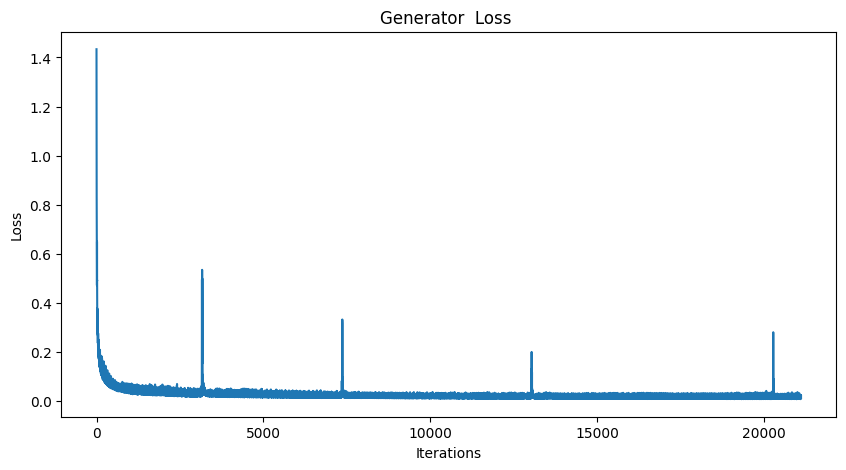

In [23]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(generator_losses)
#plt.plot(discriminator_losses, label='Discriminator Loss')
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator  Loss ')
#plt.legend()
plt.show()

After 100 epochs

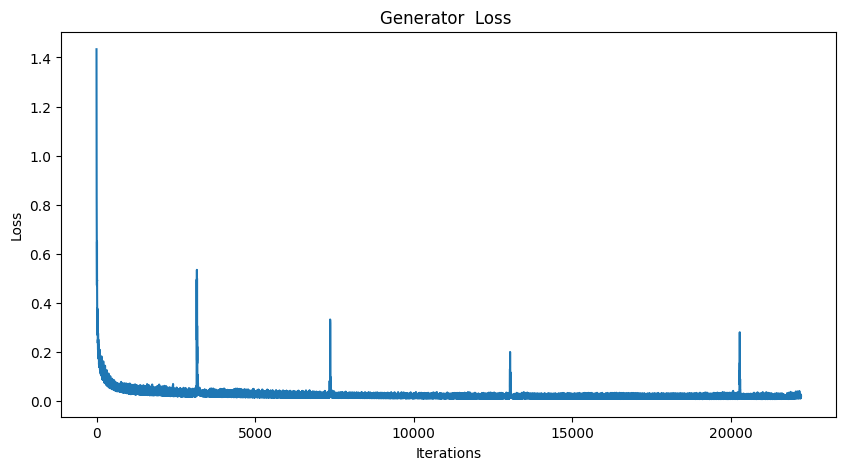

In [46]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(generator_losses)
#plt.plot(discriminator_losses, label='Discriminator Loss')
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator  Loss ')
#plt.legend()
plt.show()

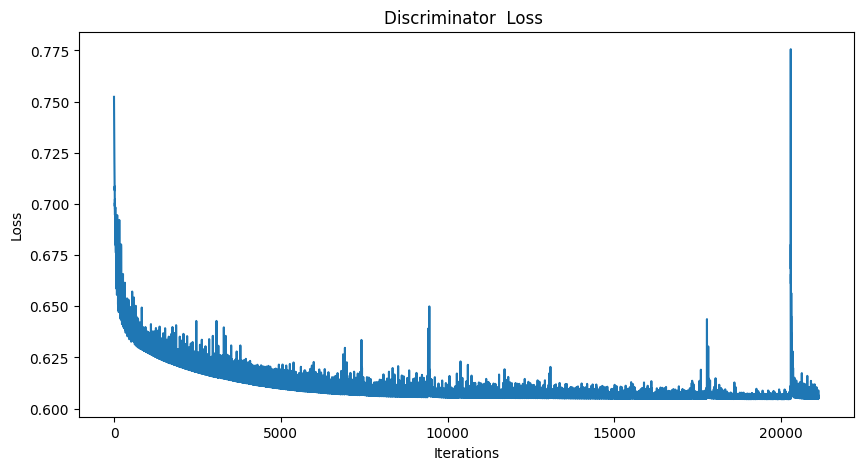

In [25]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(generator_losses)
plt.plot(discriminator_losses)
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Discriminator  Loss ')
#plt.legend()
plt.show()

After 100 epochs

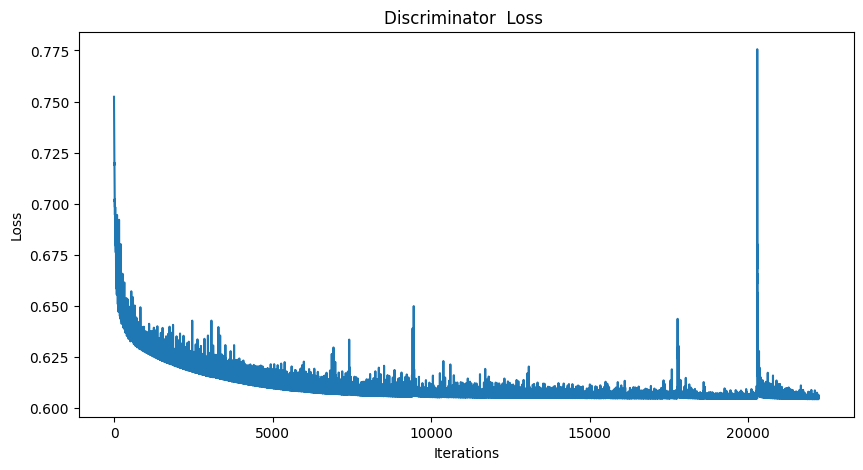

In [47]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(generator_losses)
plt.plot(discriminator_losses)
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Discriminator  Loss ')
#plt.legend()
plt.show()

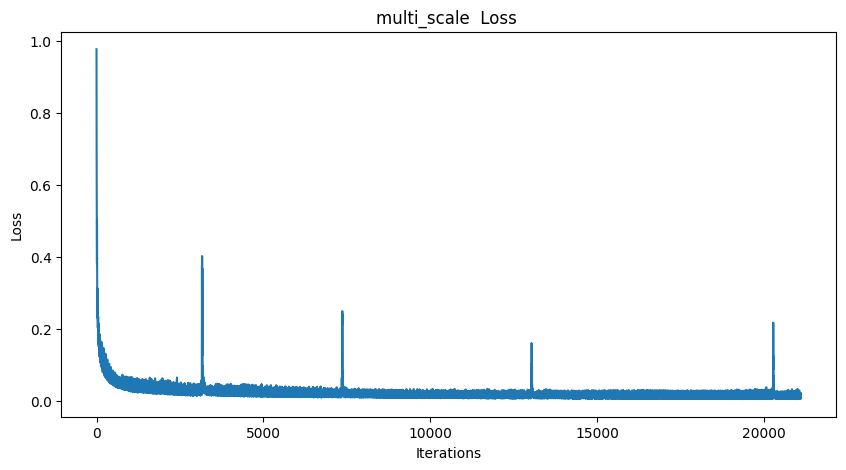

In [28]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(generator_losses)
#plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(multi_scale_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('multi_scale  Loss ')
#plt.legend()
plt.show()

After 100 epochs

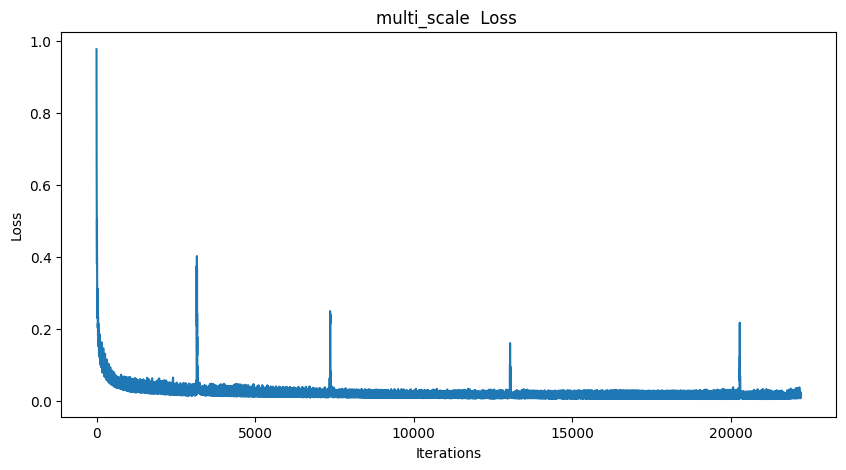

In [49]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(generator_losses)
#plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(multi_scale_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('multi_scale  Loss ')
#plt.legend()
plt.show()

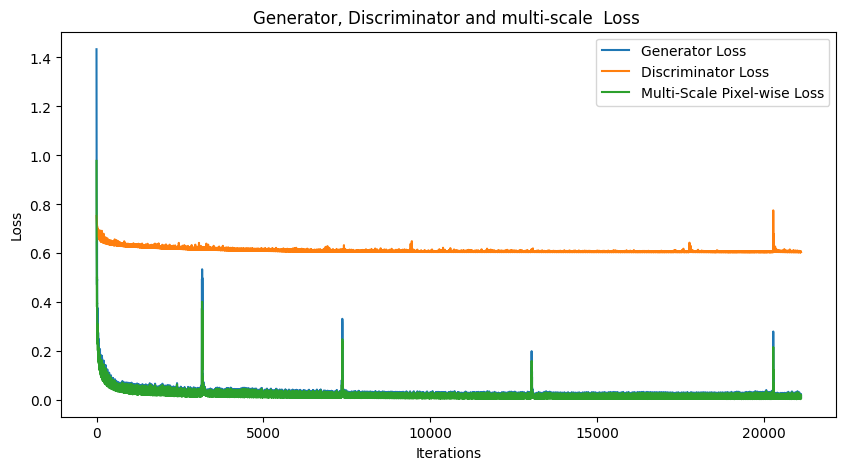

In [32]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator and multi-scale  Loss ')
plt.legend()
plt.show()

**To test**

In [110]:
import torch
import torchvision.utils as vutils
from torch.utils.data import DataLoader

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)

#from data import ImagePipeline  # Assuming this custom class still exists

device = 'cuda'
datapath = r'C:\Users\zed\Dataset\Mult_test'

# Generate frontal images from the test set
def frontalize(model, datapath, mtest):
    
    test_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=False,batch_size = 8)  # Removed batch_size
    test_pipe_loader = DataLoader(test_pipe, batch_size=mtest)  # Use DataLoader
    
    with torch.no_grad():
        model.eval()
        for data in test_pipe_loader:
             
            profile = data[0].to(device).type(torch.float)  # Correct syntax to change data type
            print(profile.shape)
            profile = profile.view(8, 1, 128, 128) 
            print(profile.shape)
            generated = model(profile).type(torch.float)  # Convert output to float

            #profile = data[0].to(device)  # Assuming profiles are in data['profiles']
            #print("length:",len(profile))
            #generated = model(profile)
            vutils.save_image(torch.cat((profile, generated.data), dim = 0), 'Test/test.jpg', nrow=8, padding=2, normalize=True)  # Removed frontal for consistency

# Load a pre-trained Pytorch model
saved_model = torch.load("FF_output/netG_99.pt")

frontalize(saved_model, datapath, 1)


C:\Users\zed\Dataset\Mult_test\frontal
C:\Users\zed\Dataset\Mult_test\pose
9
9
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])
torch.Size([1, 8, 128, 128])
torch.Size([8, 1, 128, 128])


In [146]:
os.mkdir('SACA_Test')

In [151]:
import torch
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)

#from data import ImagePipeline  # Assuming this custom class still exists

device = 'cuda'
datapath = r'C:\Users\zed\Dataset\Mult_test'


# Generate frontal images from the test set
def frontalize(model, datapath, mtest):
    
    test_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=False, batch_size=7)  # Removed batch_size
    test_pipe_loader = DataLoader(test_pipe, batch_size=mtest)  # Use DataLoader
    
    with torch.no_grad():
        model.eval()
        for data in test_pipe_loader:
             
            profile = data[0].to(device).type(torch.float)  # Correct syntax to change data type
            #print(profile.shape)
            profile = profile.view(7, 1, 128, 128) 
            #print(profile.shape)
            generated = model(profile).type(torch.float)  # Convert output to float

            # Calculate PSNR and SSIM for each generated image
            for i in range(mtest):
                calculate_psnr(profile[i], generated[i])
                #calculate_ssim(profile[i]., generated[i])
                #psnr, ssim = calculate_metrics(profile[i].cpu().numpy(), generated[i].cpu().numpy())
                #print(f"Image {i+1} - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")
                print(f"Image {i+1} - PSNR: {psnr:.2f}")

            # Save concatenated images
            vutils.save_image(torch.cat((profile, generated), dim=0), 'SACA_Test/test.jpg', nrow=7, padding=2, normalize=True)  # Removed frontal for consistency

# Load a pre-trained PyTorch model
saved_model = torch.load("SACA_output/netG_28.pt")

frontalize(saved_model, datapath, 1)


C:\Users\zed\Dataset\Mult_test\frontal
C:\Users\zed\Dataset\Mult_test\pose
7
9
Image 1 - PSNR: 38.94
Image 1 - PSNR: 38.94
Image 1 - PSNR: 38.94
Image 1 - PSNR: 38.94
Image 1 - PSNR: 38.94
Image 1 - PSNR: 38.94
Image 1 - PSNR: 38.94


**FF-GAN2 Training**

In [16]:
from __future__ import print_function
import time
import math
import random
import os
from os import listdir
from os.path import join
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#from nvidia.dali.plugin.pytorch import DALIGenericIterator

#from data import ImagePipeline
#import network

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)
# Where is your training dataset at?
datapath =r"C:\Users\zed\Dataset\\Grayscale_Multipie_1000"

# You can also choose which GPU you want your model to be trained on below:
gpu_id = 0
device = torch.device("cuda", gpu_id)

checkpoint_dir = "checkpoints"

"""train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=30, device_id=gpu_id)
train_pipe.build()
m_train = train_pipe.epoch_size()
print("Size of the training set: ", m_train)
train_pipe_loader = DALIGenericIterator(train_pipe, ["profiles", "frontals"], m_train)"""
# Assuming you have the modified ImagePipeline class from the previous responses
train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=32, device_id=gpu_id)
# No need to call build() without DALI

# Use a standard PyTorch DataLoader instead of DALIGenericIterator
#train_pipe_loader = DataLoader(train_pipe, batch_size=train_pipe.batch_size)
m_train = train_pipe.epoch_size()
#train_pipe_loader = DataLoader(train_pipe, batch_size=32,)
train_pipe_loader = DataLoader(train_pipe,)

criterion = nn.BCEWithLogitsLoss()

C:\Users\zed\Dataset\\Grayscale_Multipie_1000\frontal
C:\Users\zed\Dataset\\Grayscale_Multipie_1000\pose
1008
86


In [154]:
try:
    os.mkdir('FF1_output')
except OSError:
    pass

try:
    os.mkdir('FF1_checkpoints')
except OSError:
    pass
    

In [44]:
checkpoint_dir1 = "FF1_checkpoints"

In [ ]:
for epoch in range(100):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            #errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FF1_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FF1_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FF1_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FF1_output/netG_%d.pt' % epoch)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 1008/1008 [3:49:30<00:00, 13.66s/it]


First training epoch completed in  14014.450685977936  seconds
[1/30] Training absolute losses: L1 0.0546584 ; L2 0.0050118 BCE 0.7304743; Average PSNR: 27.56; Average SSIM: 0.9440


Epoch 1: 100%|███████████████████████████████████████████████████████████████████| 1008/1008 [4:00:26<00:00, 14.31s/it]


[2/30] Training absolute losses: L1 0.0214480 ; L2 0.0004164 BCE 0.7326897; Average PSNR: 33.94; Average SSIM: 0.9923


Epoch 2:  89%|████████████████████████████████████████████████████████████▋       | 899/1008 [3:01:09<41:55, 23.08s/it]

In [ ]:
latest_epoch = 1
checkpoint_path = os.path.join(checkpoint_dir1, f"checkpoint_{latest_epoch}.pth")
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer states
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load training progress
loss_L1 = checkpoint['loss_L1']
loss_L2 = checkpoint['loss_L2']
loss_gan = checkpoint['loss_gan']
psnr_values = checkpoint['psnr_values']
ssim_values = checkpoint['ssim_values']
losses_L1 = checkpoint['losses_L1']
losses_L2 = checkpoint['losses_L2']
losses_gan = checkpoint['losses_gan']
discriminator_losses = checkpoint['discriminator_losses']
generator_losses = checkpoint['generator_losses']
multi_scale_losses = checkpoint['multi_scale_losses']
avg_generator_losses = checkpoint['avg_generator_losses']
avg_discriminator_losses = checkpoint['avg_discriminator_losses']
avg_multi_scale_losses = checkpoint['avg_multi_scale_losses']

# Start training from the loaded epoch
start_epoch = checkpoint['epoch'] + 1

for epoch in range(start_epoch,100):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            #errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/100] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FF1_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FF1_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FF1_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FF1_output/netG_%d.pt' % epoch)

Epoch 2:  71%|██████████████████████████████████████████████▊                   | 714/1008 [1:52:47<1:28:10, 17.99s/it]

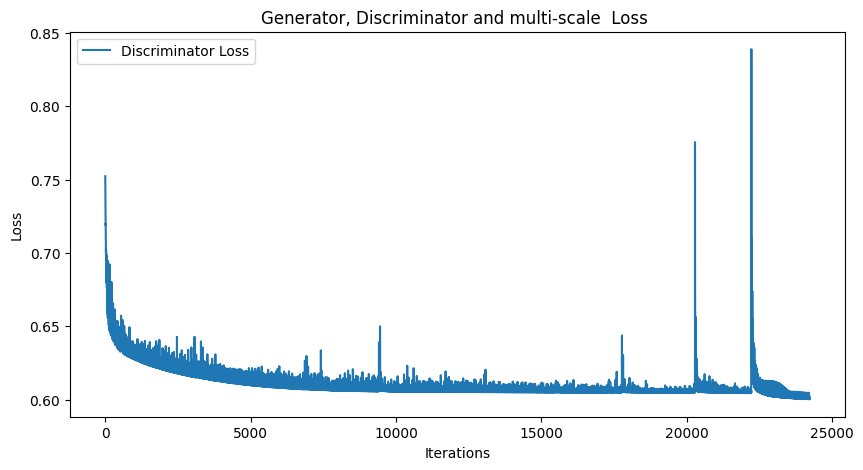

In [36]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator and multi-scale  Loss ')
plt.legend()
plt.show()

**To check CPU or GPU**

In [20]:
for epoch in range(100):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            #errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FF_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FF_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FF_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FF_output/netG_%d.pt' % epoch)

Epoch 0:  54%|██████████████████████████████████████                                 | 118/220 [05:12<04:30,  2.65s/it]


KeyboardInterrupt: 